# Homework 4: Using pre-trained BERT vectors for text classification

#### Christopher W. Hong

## The Road Ahead

I break the notebook into separate steps. Feel free to use the links below to navigate the notebook.

- [Step 1](#step1): Clone the BERT repository
- [Step 2](#step2): Download a pre-trained BERT model
- [Step 3](#step3): Download handout materials and re-format the datafiles
- [Step 4](#step4): Run the texts through BERT (feature extraction)
- [Step 5](#step5): Train a text categorization model using the features derived from BERT   
- [Step 6](#step6): Model performance on test data

## How to Run

- Enviroment:
    - OS: Mac/Ubuntu18.04
    - Python 3.7*
    - Pandas
    - Numpy
    - Matplotlib
    - Searborn
    - Wget
    - Tensorflow 1.14/1.15
    - Scikit-learn

- You could run all the steps one by one, it will **automatically delete and recreate** the following directories and files.
- Assumption on directories and files:
    - **BERT_BASE_DIR**: `$HOME/Documents/repos/bert`
    - **BERT_DATA_DIR**: `$BERT_BASE_DIR/models/uncased_L-12_H-768_A-12`
    - **HANDOUT_DIR**: `$HOME/Documents/repos/handout`
        - Contains `run_bert_fv.sh, Example Model Training with BERT vectors.ipynb, data`
    - **HANDOUT_DATA_DIR**: `$HOME/Documents/repos/handout/data`
        - Contains `lang_id_train.csv, lang_id_eval.csv, lang_id_test.csv`     
    - Same directory as this `.ipynb`
        - Contains `bert_input_data`
            - Contains `train.txt, eval.txt, test.txt`
        - Contain `bert_output_data`
            - Contains `train.jsonlines, eval.jsonlines, test.jsonlines`
- You could skip [Step 4](#step4) that is most time consuming. Or run from [Step 5](#step5), but I will make the above directory and file assumption   

In [29]:
import os
import pandas as pd
import numpy as np
import sys
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id='step1'></a>
## Step 1: Clone the BERT repository

- **BERT_BASE_DIR**: `$HOME/Documents/repos/bert`
- `load_bert_repo` function will **remove** the **BERT_BASE_DIR** directory if exits and will clone the BERT repo into the aforementioned location again

In [2]:
def load_bert_repo():
    """
    Load BERT repo.
    """
    HOME = os.getenv('HOME')
    
    # Check if repos directory exists in Documents 
    if not os.path.isdir(os.path.join(HOME, 'Documents/repos')):
        !mkdir $HOME/Documents/repos
    
    # Check if bert directory exists in Documents/repos
    if os.path.isdir(os.path.join(HOME, 'Documents/repos/bert')):
        !rm -rf $HOME/Documents/repos/bert
        
    # Clone bert repo
    print('Loading BERT repo ...\n')
    !git clone https://github.com/google-research/bert.git $HOME/Documents/repos/bert
    print('\nBERT repo loaded\n')
    
    !ls $HOME/Documents/repos/bert

In [3]:
load_bert_repo()

Loading BERT repo ...

Cloning into '/home/chris/Documents/repos/bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 300.28 KiB | 3.62 MiB/s, done.
Resolving deltas: 100% (185/185), done.

BERT repo loaded

CONTRIBUTING.md		    predicting_movie_reviews_with_bert_on_tf_hub.ipynb
create_pretraining_data.py  README.md
extract_features.py	    requirements.txt
__init__.py		    run_classifier.py
LICENSE			    run_classifier_with_tfhub.py
modeling.py		    run_pretraining.py
modeling_test.py	    run_squad.py
multilingual.md		    sample_text.txt
optimization.py		    tokenization.py
optimization_test.py	    tokenization_test.py


<a id='step2'></a>
## Step 2: Download a pre-trained BERT model

- **BERT_DATA_DIR**: `$BERT_BASE_DIR/models/uncased_L-12_H-768_A-12`
- `load_bert_mdoel` function will remove the **BERT_DATA_DIR** directory if exists and will download the pre-train BERT model and uncompress it into the aforementioned location again

In [4]:
def load_bert_model():
    """
    Load pre-train BERT model.
    """
    HOME = os.getenv('HOME')
    
    if not os.path.isdir(os.path.join(HOME, 'Documents/repos/bert')):
        load_bert_repo()

    if os.path.isdir(os.path.join(HOME, 'Documents/repos/bert/models')):
        !rm -rf $HOME/Documents/repos/bert/models
        
    # Download uncased BERT-Base
    print('Loading uncased BERT model ...\n')
    !wget -P $HOME/Documents/repos/bert/models https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip   
    print('\nBERT model loaded\n')

    # unzip uncased BERT-Base
    print('Decompressing BERT model ...\n')
    !unzip $HOME/Documents/repos/bert/models/uncased_L-12_H-768_A-12.zip -d $HOME/Documents/repos/bert/models/  
    print('\nDecompressing completed\n')

    # Remove zipfile
    print('Removing BERT model compressed file ...\n')
    !rm -rf $HOME/Documents/repos/bert/models/uncased_L-12_H-768_A-12.zip
    print('BERT model compressed removed\n')
    
    !ls $HOME/Documents/repos/bert/models/uncased_L-12_H-768_A-12

In [5]:
load_bert_model()

Loading uncased BERT model ...

--2020-04-20 10:11:04--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.208, 2607:f8b0:4009:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘/home/chris/Documents/repos/bert/models/uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  10.8MB/s    in 37s     

2020-04-20 10:11:41 (10.6 MB/s) - ‘/home/chris/Documents/repos/bert/models/uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]


BERT model loaded

Decompressing BERT model ...

Archive:  /home/chris/Documents/repos/bert/models/uncased_L-12_H-768_A-12.zip
   creating: /home/chris/Documents/repos/bert/models/uncased_L-12_H-768_A-12/
  inflating: /home/chris/Documents/repos/bert/models/uncased_L-12_H-768_A

<a id='step3'></a>
## Step 3: Download handout materials and re-format the datafiles

### Step 3.1: Download handout materials

- **HANDOUT_DIR**: `$HOME/Documents/repos/handout`

- `load_handout` function will remove the **HANDOUT_DIR** if exists and will download the handout materials to the same loacation again

In [6]:
def load_handout():
    """
    Load HW4 handout.
    """
    HOME = os.getenv('HOME')
    
    if os.path.isdir(os.path.join(HOME, 'Documents/repos/handout')):
        !rm -rf $HOME/Documents/repos/handout
        
    # Download handout
    print('Loading HW4 handout ...\n')
    !wget -P $HOME/Documents/repos/ http://www.cs.iit.edu/~cs585/hw4/hw4-handout.tgz
    print('\nHW4 handout loaded\n')

    # Decompress handout
    print('Decompressing HW4 handout ...\n')
    !tar -xvzf $HOME/Documents/repos/hw4-handout.tgz -C $HOME/Documents/repos
    print('\nDecompressing completed\n')

    # Remove zipfile
    print('Removing HW4 handout compressed file ...\n')
    !rm -rf $HOME/Documents/repos/hw4-handout.tgz
    print('HW4 handout compressed file removed\n')
    
    !ls $HOME/Documents/repos/handout

In [7]:
load_handout()

Loading HW4 handout ...

--2020-04-20 10:13:58--  http://www.cs.iit.edu/~cs585/hw4/hw4-handout.tgz
Resolving www.cs.iit.edu (www.cs.iit.edu)... 216.47.157.249
Connecting to www.cs.iit.edu (www.cs.iit.edu)|216.47.157.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2758901 (2.6M) [application/x-gzip]
Saving to: ‘/home/chris/Documents/repos/hw4-handout.tgz’

hw4-handout.tgz     100%[===================>]   2.63M  5.79MB/s    in 0.5s    

2020-04-20 10:13:59 (5.79 MB/s) - ‘/home/chris/Documents/repos/hw4-handout.tgz’ saved [2758901/2758901]


HW4 handout loaded

Decompressing HW4 handout ...

handout/
handout/run_bert_fv.sh
handout/Example Model Training with BERT vectors.ipynb
handout/data/
handout/data/lang_id_test.csv
handout/data/lang_id_train.csv
handout/data/lang_id_eval.csv

Decompressing completed

Removing HW4 handout compressed file ...

HW4 handout compressed file removed

 data  'Example Model Training with BERT vectors.ipynb'   run_bert_fv.sh


### Step 3.2: Re-format the train, eval and test dataset

- **HANDOUT_DATA_DIR**: `$HOME/Documents/repos/handout/data`
- `etl_text` function will extract train, eval and test dataset `.csv` fiels from **HANDOUT_DATA_DIR** and load **text** columns into `.txt` file format into current directory `bert_input_data` folder

In [8]:
def etl_text():
    """
    Extract tain, eval and test data into pandas DataFrame, respectively.
    Load attribute text into .txt file.
    """
    HOME = os.getenv('HOME')
    
    if not os.path.isdir(os.path.join(HOME, 'Documents/repos/handout')):
        load_handout()

    if os.path.isdir('bert_input_data'):
        !rm -rf bert_input_data
    os.makedirs('bert_input_data')
    
    # Extract and load
    for file in os.listdir(os.path.join(HOME, 'Documents/repos/handout/data/')):
        print('Extracting', file)
        df = pd.read_csv(os.path.join(HOME, 'Documents/repos/handout/data',file))
        print(file, 'Extracted\n')
        print('Saving ' + file[8:-4] + '.txt')
        df['text'].to_csv('bert_input_data/' + file[8:-4] + '.txt', header=None, index=False)
        print(file[8:-4] + '.txt saved\n')

    !ls ./bert_input_data

In [9]:
etl_text()

Extracting lang_id_train.csv
lang_id_train.csv Extracted

Saving train.txt
train.txt saved

Extracting lang_id_eval.csv
lang_id_eval.csv Extracted

Saving eval.txt
eval.txt saved

Extracting lang_id_test.csv
lang_id_test.csv Extracted

Saving test.txt
test.txt saved

eval.txt  test.txt  train.txt


<a id='step4'></a>
## Step 4: Run the texts through BERT (feature extraction)

- `run_bert_fv` function will run the `run_bert_fv.sh` script in **HANDOUT_DATA_DIR**.
- Feature vectors generated from texts will save into current directory `bert_output_data`
- **Warning**: This might take about 45 minutes without GPU support. Tensorflow compatible verstion 1.14/1.15
- You might wanna skip testing this step and go to [Step5](#step5)

In [10]:
def run_bert_fv():
    """
    Run extract_features.py to generate feature vectors to represent each document.
    """
    print('Extracting features ...\n')
    !sh $HOME/Documents/repos/handout/run_bert_fv.sh
    print('\nFeatures extracted\n')
    
    !ls ./bert_output_data

In [ ]:
run_bert_fv()

<a id='step5'></a>
## Step 5: Train a text categorization model using the features derived from BERT

<a id='step5.1'></a>
### Step 5.1: Extract feature vectors
- I assump that `train.jsonlines, eval.jsonlines and test.jsonlines` files are available and located in `bert_output_data` folder that is under the same folder as this `.ipynb` file  if [Step4](#step4) is skipped.

- `extract_feature_vectors` function extract feature vectors from the aformentioned `jsonlines` files and load into `pandas DataFrame` format

In [12]:
def extract_feature_vectors(file, path):
    """
    Extract feature vectors from jsonlines file.
    """
    try:
        print('Extracting', file, '...\n')
        bert_vectors = []
        n_samples = 1
        with open(os.path.join(path, file), "rt") as infile:
            for line in infile:
                bert_data = json.loads(line)
                for t in bert_data["features"]:
                    # Only extract the [CLS] vector used for classification
                    if t["token"] == "[CLS]":
                        # We only use the representation at the final layer of the network
                        bert_vectors.append(t["layers"][0]["values"])
                        sys.stdout.write("\rProgress: {} samples extracted".format(n_samples))
                        sys.stdout.flush()
                        n_samples += 1
                        break
        print('\n', file, 'extracted\n')
        return pd.DataFrame(bert_vectors)
    except:
        print('Please setup the correct data dir')

In [13]:
# Feel free to modify the path so that it can refer to jsonlines files
BERT_OUTPUT_DATA_DIR = 'bert_output_data'

In [14]:
# Extract feature vectors from train file
X_train = extract_feature_vectors('train.jsonlines', path=BERT_OUTPUT_DATA_DIR)
print('Shape of train features:', X_train.shape, '\n')

# Extract feature vectors  from eval file
X_eval = extract_feature_vectors('eval.jsonlines', path=BERT_OUTPUT_DATA_DIR)
print('Shape of eval features:', X_eval.shape, '\n')

# Extract feature vectors  from test file
X_test = extract_feature_vectors('test.jsonlines', path=BERT_OUTPUT_DATA_DIR)
print('Shape of test features:', X_test.shape, '\n')

Extracting train.jsonlines ...

Progress: 6000 samples extracted
 train.jsonlines extracted

Shape of train features: (6000, 768) 

Extracting eval.jsonlines ...

Progress: 2000 samples extracted
 eval.jsonlines extracted

Shape of eval features: (2000, 768) 

Extracting test.jsonlines ...

Progress: 2000 samples extracted
 test.jsonlines extracted

Shape of test features: (2000, 768) 



In [15]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.092756,0.527301,-0.070479,0.004424,0.027787,0.309443,0.413566,0.436307,-0.400305,-0.343838,...,0.023732,-0.235068,-0.023495,-0.020063,0.448484,-0.101084,-0.178424,-0.215775,0.526235,0.498662
1,0.344250,0.088797,0.093540,-0.538812,-0.220419,-0.537521,0.300110,0.839316,0.117409,-0.258275,...,-0.309531,0.044133,-0.089665,-0.508454,0.278641,0.118530,0.065913,-0.080332,0.213616,0.465394
2,-0.029146,0.431235,0.454687,-0.780888,-0.168914,-0.036099,0.804928,0.926451,-0.171232,-0.763028,...,-0.244614,-0.286854,-0.075160,-0.189794,0.140126,0.222708,-0.118831,-0.512232,0.317563,0.262735
3,0.362146,-0.093412,-0.144733,0.338132,0.018647,-0.013852,0.160238,0.585432,-0.555063,-0.132848,...,-0.233849,0.208920,0.153276,0.043740,0.445221,0.021546,-0.195900,-0.065972,0.517348,0.510388
4,0.388101,-0.109796,0.063145,0.153027,0.194651,0.077180,0.223833,0.637487,-0.519473,-0.439355,...,0.156166,-0.366463,0.204668,0.099465,0.279066,0.033868,-0.050661,0.020124,0.553007,0.055360


<a id='step5.2'></a>
### Step 5.2: Re-encode labels

- I assump that the `train.csv, eval.csv and test.csv` are located in **HANDOUT_DATA_DIR**: `$HOME/Documents/repos/handout/data`

In [16]:
# Feel free to midity the original data path so that it can refer to .csv files
HANDOUT_DATA_DIR = os.path.join(os.getenv('HOME'), 'Documents/repos/handout/data/')

In [17]:
try:
    train_data = pd.read_csv(HANDOUT_DATA_DIR + 'lang_id_train.csv')
    eval_data = pd.read_csv(HANDOUT_DATA_DIR + 'lang_id_eval.csv')
    test_data = pd.read_csv(HANDOUT_DATA_DIR + 'lang_id_test.csv')
except:
    print('Please setup the correct data dir')

In [18]:
train_data.head()

,native_language,text
0,Japanese,"who, whom, whose I have often thinking that, I..."
1,Japanese,books I love reading. It's been one of my hobb...
2,Japanese,change job I want to change job. The company t...
3,Japanese,the origin of Japanese I like to learn about a...
4,Japanese,"Marunouchi Today, I am going go to Marunouchi,..."


In [19]:
train_data['native_language'].value_counts()

Mandarin      600
Vietnamese    600
Japanese      600
Arabic        600
Russian       600
Spanish       600
Polish        600
Korean        600
Thai          600
Cantonese     600
Name: native_language, dtype: int64

In [20]:
# Re-encode labels from text to int
int2lng = dict(enumerate(train_data['native_language'].unique()))
print(int2lng)

lng2int = dict([(v, k) for k, v in int2lng.items()])
print(lng2int)

{0: 'Japanese', 1: 'Korean', 2: 'Vietnamese', 3: 'Mandarin', 4: 'Russian', 5: 'Thai', 6: 'Spanish', 7: 'Cantonese', 8: 'Polish', 9: 'Arabic'}
{'Japanese': 0, 'Korean': 1, 'Vietnamese': 2, 'Mandarin': 3, 'Russian': 4, 'Thai': 5, 'Spanish': 6, 'Cantonese': 7, 'Polish': 8, 'Arabic': 9}


In [21]:
y_train = train_data['native_language'].map(lng2int)
y_eval = eval_data['native_language'].map(lng2int)
y_test = test_data['native_language'].map(lng2int)

In [22]:
y_train.value_counts()

7    600
3    600
6    600
2    600
9    600
5    600
1    600
8    600
4    600
0    600
Name: native_language, dtype: int64

<a id='step5.3'></a>
### Step 5.3 Train a Multinomial LogisticRegression Model

In [24]:
lr_model = LogisticRegression(multi_class='multinomial', random_state=0)
lr_model.fit(X_train, y_train)
y_pred_train = lr_model.predict(X_train)
y_pred_eval = lr_model.predict(X_eval)

target_names = list(lng2int.keys())
print('train metrics\n', classification_report(y_train, y_pred_train, target_names=target_names))
print('eval metrics:\n', classification_report(y_eval, y_pred_eval, target_names=target_names))

train metrics
               precision    recall  f1-score   support

    Japanese       0.66      0.71      0.69       600
      Korean       0.65      0.63      0.64       600
  Vietnamese       0.62      0.60      0.61       600
    Mandarin       0.60      0.58      0.59       600
     Russian       0.69      0.73      0.71       600
        Thai       0.74      0.69      0.71       600
     Spanish       0.64      0.67      0.66       600
   Cantonese       0.56      0.58      0.57       600
      Polish       0.69      0.66      0.68       600
      Arabic       0.69      0.67      0.68       600

    accuracy                           0.65      6000
   macro avg       0.65      0.65      0.65      6000
weighted avg       0.65      0.65      0.65      6000

eval metrics:
               precision    recall  f1-score   support

    Japanese       0.51      0.56      0.53       200
      Korean       0.50      0.47      0.48       200
  Vietnamese       0.44      0.42      0.43     

<a id='step6'></a>
## Step 6: Model performance on test data

In [34]:
# Generate classification report on test data
y_pred_test = lr_model.predict(X_test)
print('test metrics:\n', classification_report(y_test, y_pred_test, target_names=target_names))

test metrics:
               precision    recall  f1-score   support

    Japanese       0.48      0.50      0.49       200
      Korean       0.50      0.45      0.47       200
  Vietnamese       0.41      0.38      0.39       200
    Mandarin       0.34      0.35      0.34       200
     Russian       0.51      0.59      0.55       200
        Thai       0.66      0.60      0.63       200
     Spanish       0.49      0.51      0.50       200
   Cantonese       0.34      0.35      0.35       200
      Polish       0.48      0.49      0.48       200
      Arabic       0.50      0.46      0.48       200

    accuracy                           0.47      2000
   macro avg       0.47      0.47      0.47      2000
weighted avg       0.47      0.47      0.47      2000



In [33]:
# Generate confution matrix on test data
conf_mx = confusion_matrix(y_test, y_pred_test)
print(conf_mx)

[[100  23  10  11  11   4   9  13  10   9]
 [ 20  90  10  12  13  16   8  18   6   7]
 [  9  12  75  25  14  10  13  19  12  11]
 [ 16  13  15  70  11   3  12  40   9  11]
 [ 12   6   8   5 118   0  11   6  25   9]
 [  6  12  13   7   3 120  10  13   6  10]
 [ 10   3  18  13  12   4 102   5  17  16]
 [ 16  12  13  48   7  11   5  71   8   9]
 [  9   2   9   6  31   7  16  12  98  10]
 [  9   7  14  10  12   7  22  13  15  91]]


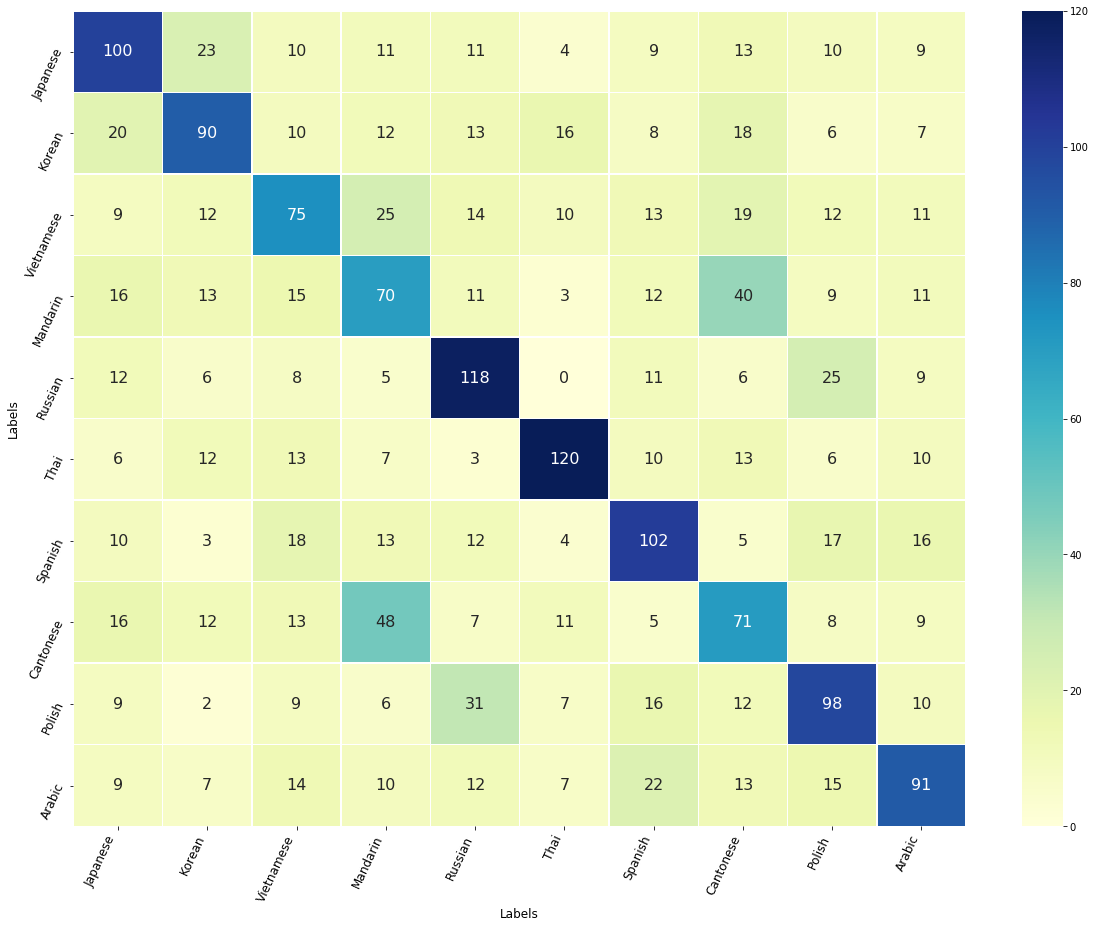

In [35]:
# Generate heatmap on test data
cm = pd.DataFrame(conf_mx, index=[target_names], columns=target_names)
plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True, annot_kws={'size':16}, linewidths=0.5, cmap='YlGnBu', fmt="d")
plt.xticks(rotation=65, horizontalalignment='right', fontsize=12)
plt.yticks(rotation=65, horizontalalignment='right', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Labels', fontsize=12)
plt.show();

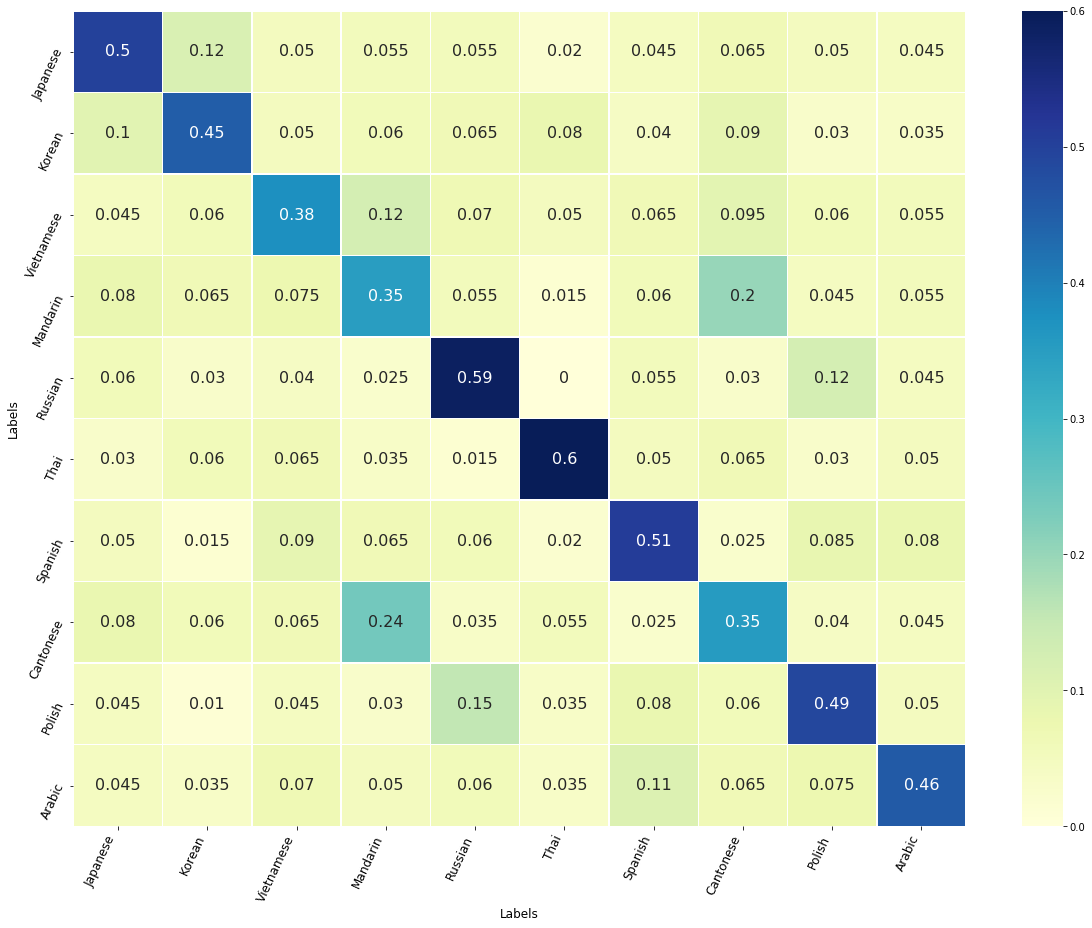

In [32]:
cm = pd.DataFrame(conf_mx/200, index=[target_names], columns=target_names)
plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True, annot_kws={'size':16}, linewidths=0.5, cmap='YlGnBu')
plt.xticks(rotation=65, horizontalalignment='right', fontsize=12)
plt.yticks(rotation=65, horizontalalignment='right', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Labels', fontsize=12)
plt.show();